<a href="https://colab.research.google.com/github/vduran18/Neural-Nets/blob/master/Duran_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title
pip install --upgrade tensorflow

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.2.0rc3)


In [ ]:
pip install --upgrade pip

Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (20.1)


In [ ]:
pip install git+git://github.com/fchollet/keras.git --upgrade --no-deps

  Cloning git://github.com/fchollet/keras.git to /tmp/pip-req-build-c2cg36jw
  Running command git clone -q git://github.com/fchollet/keras.git /tmp/pip-req-build-c2cg36jw
  Created wheel for Keras: filename=Keras-2.3.1-py3-none-any.whl size=365120 sha256=b464debca2e47958813227a8cd1ee98dbdd36d8903f6b2d05e694ed399b716f7
  Stored in directory: /tmp/pip-ephem-wheel-cache-c4sybxp7/wheels/a0/bf/a7/361bb05a62dd1a245d89516e044c7fc00bbef30039506f1261
Successfully built Keras
  Attempting uninstall: Keras
    Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [ ]:
#import packages
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import RandomNormal, RandomUniform, TruncatedNormal
from tensorflow.keras import optimizers, losses
from tensorflow.keras import callbacks
from time import time
import seaborn as sns
from scipy.stats import norm
from pandas import DataFrame as df
from sklearn.metrics import plot_confusion_matrix
import itertools

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving HW3_act.csv to HW3_act (1).csv


In [ ]:
import io
dat = pd.read_csv(io.BytesIO(uploaded['HW3_act.csv']))

In [ ]:
dat.tail()

,XLRN,NBIX,VRTX,GILD,IMMU,EPZM,TECH,GWPH,ALNY,MNTA,GRFS,PTCT,XNCR,ALKS,JAZZ,BMRN,MYL,BIIB,INCY,FATE,CCXI,ICPT,ARWR,CBPO,SGEN,BLUE,EXEL,SRPT,ARNA,MRTX,ACAD,ILMN,HALO,HZNP,FOLD,AGIO,REGN,AMRN,GLPG,NKTR,AMGN,INSM,IOVA,ALXN,PCRX,SNY,IONS,UTHR,LMNX,LGND
1002,1.266021,1.806473,1.400678,0.826069,3.130641,0.703226,1.271379,1.456801,1.546697,0.940393,1.249198,0.633954,1.302611,0.991164,0.899187,0.995925,0.889458,1.029069,1.051112,1.260536,0.902052,0.351869,0.553250,0.876995,1.160614,2.283358,2.919426,1.946122,1.006776,1.066558,0.948532,1.243680,1.543975,0.861781,1.718732,0.929615,0.924004,1.781384,1.845189,3.627858,1.145831,1.803037,1.111653,0.785239,0.718489,0.920100,1.094650,1.053003,1.041492,1.442663
1003,1.283726,1.803958,1.406562,0.825956,3.184065,0.728746,1.272865,1.490530,1.555681,0.929905,1.249198,0.632430,1.306772,1.003684,0.916050,0.999888,0.894111,1.029971,1.046614,1.411082,0.886391,0.363471,0.565180,0.902329,1.164090,2.303070,3.012547,1.964898,1.056336,1.060714,0.987433,1.234974,1.557815,0.864095,1.745436,0.956806,0.939598,1.781384,1.855905,3.753604,1.143688,1.811094,1.077967,0.788148,0.738832,0.918172,1.091852,1.151053,1.034194,1.452781
1004,1.294829,1.854508,1.415435,0.829137,3.365706,0.737253,1.270091,1.465180,1.604093,0.947385,1.263134,0.632811,1.327581,1.019755,0.914425,0.998787,0.888400,1.030905,1.058792,1.491972,0.869165,0.352878,0.572636,0.871267,1.187767,2.287809,3.052172,1.973243,1.101131,1.078246,0.995213,1.242181,1.593954,0.868143,1.764857,0.967203,0.931498,1.742184,1.865629,3.693546,1.144468,1.811094,1.077967,0.791982,0.733949,0.923527,1.095081,1.160643,1.025854,1.474083
1005,1.299030,1.896004,1.411886,0.823456,3.487512,0.737253,1.275639,1.449604,1.620564,0.961368,1.270380,0.636621,1.341255,1.035078,0.924853,0.996145,0.885439,1.031742,1.046395,1.368390,0.925543,0.351477,0.592022,0.871157,1.195587,2.285266,3.064060,1.968375,1.100496,1.101623,1.010773,1.254057,1.592416,0.864095,1.781850,0.969602,0.928418,1.763962,1.880116,3.784884,1.138232,1.807066,1.118390,0.795023,0.739645,0.922456,1.091637,1.144992,1.031066,1.476852
1006,1.273523,1.951332,1.399651,0.813913,3.453321,0.711733,1.283465,1.418023,1.585253,0.975352,1.277627,0.635478,1.303205,1.022745,0.911851,0.981722,0.894958,1.026073,1.039044,1.372884,0.931807,0.327432,0.548776,0.867633,1.162135,2.264918,3.011556,1.934647,1.079211,1.066558,0.976087,1.259649,1.557815,0.844430,1.746650,0.914420,0.911781,1.746540,1.860668,3.736087,1.129464,1.794405,1.077967,0.790594,0.742900,0.921171,1.082598,1.135095,1.026896,1.458426


Preprocessing was done separately in a different .ipynb notebook. The code will be attached to the end of the report.

Create a 50x1 matrix where each row is the 1x5 line vector [Yj(t-4) Yj(t-3) Yj(t-2) Yj(t-1) Yj(t)] where t= recent day 

The Mt matrix has the correct 50x5 shape. Next, the matrix will be converted into a long 1x250 line vector Xt

In [ ]:
dat.iloc[5:1006,:]

,XLRN,NBIX,VRTX,GILD,IMMU,EPZM,TECH,GWPH,ALNY,MNTA,GRFS,PTCT,XNCR,ALKS,JAZZ,BMRN,MYL,BIIB,INCY,FATE,CCXI,ICPT,ARWR,CBPO,SGEN,BLUE,EXEL,SRPT,ARNA,MRTX,ACAD,ILMN,HALO,HZNP,FOLD,AGIO,REGN,AMRN,GLPG,NKTR,AMGN,INSM,IOVA,ALXN,PCRX,SNY,IONS,UTHR,LMNX,LGND
5,1.470073,0.459980,0.712808,0.844134,1.106943,2.104006,0.945435,0.504864,0.808909,1.367590,1.080018,0.687291,0.579665,0.804480,0.921467,0.772651,0.953973,0.933248,0.616230,1.487478,1.000714,1.546196,1.714925,0.304668,0.898211,0.280158,0.712273,0.668990,1.925233,1.065973,0.770885,0.661851,1.241793,0.496826,0.292524,0.426100,0.649034,0.932069,0.433018,0.775745,0.772179,1.126826,1.082009,0.886319,1.057798,1.088695,0.993278,0.834270,0.961738,0.617006
6,1.414859,0.481609,0.730460,0.850609,1.303543,2.291722,0.946723,0.525703,0.826128,1.378777,1.083084,0.742915,0.571341,0.843349,0.938330,0.768687,0.972375,0.964039,0.657919,1.485231,0.980355,2.498788,1.804399,0.316454,0.933401,0.277106,0.737039,0.675597,2.023718,1.064220,0.782231,0.672632,1.264091,0.491620,0.296166,0.437776,0.665428,0.971268,0.463381,0.800143,0.766334,1.179197,1.075272,0.893856,1.068051,1.088481,1.024486,0.851532,0.978418,0.631704
7,1.389653,0.469034,0.719532,0.830955,1.183874,2.178865,0.937905,0.534189,1.163891,1.368289,1.102037,0.757011,0.549938,0.866708,0.994402,0.755696,0.956934,0.913665,0.648484,1.444786,0.947468,2.042165,1.837207,0.315242,0.904076,0.275326,0.784590,0.698198,2.103142,1.167077,0.755973,0.656835,1.195658,0.487572,0.274317,0.485601,0.651605,0.940780,0.472708,0.774494,0.756007,1.168262,1.131865,0.863446,1.036154,1.071772,1.016307,0.830510,0.993014,0.632450
8,1.455969,0.487644,0.741387,0.851973,1.228750,2.109110,0.951181,0.547831,1.119971,1.363395,1.112628,0.833208,0.532102,0.896794,0.985192,0.785422,0.977663,0.958113,0.696207,1.471749,0.925543,1.429896,1.914751,0.311828,0.951213,0.280412,0.813318,0.708977,2.166681,1.167077,0.788066,0.700535,1.234872,0.487572,0.279173,0.569093,0.728338,0.901580,0.480249,0.821414,0.764580,1.224086,1.145339,0.910052,1.060240,1.087410,1.048376,0.850458,1.008652,0.658332
9,1.462271,0.481860,0.735690,0.854699,1.183874,2.126124,0.951974,0.547831,1.055712,1.362696,1.112071,0.938739,0.582043,0.890067,0.999549,0.789716,0.961587,0.955697,0.684797,1.491972,0.955298,1.576406,1.938611,0.316124,0.953385,0.286771,0.799449,0.694721,2.322352,1.261752,0.777692,0.698287,1.237179,0.490463,0.280386,0.674818,0.697223,1.045311,0.466953,0.823290,0.769711,1.224086,1.192501,0.905887,1.053567,1.095336,1.025777,0.847696,1.023769,0.670793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001,1.250717,1.802700,1.389938,0.829591,2.951136,0.672034,1.275738,1.445952,1.532598,0.933401,1.236377,0.624048,1.324014,0.981447,0.904131,1.007925,0.887554,1.038796,1.057146,1.139201,0.919279,0.349964,0.504039,0.879088,1.146278,2.357118,2.754979,1.921782,1.003917,0.973051,0.931999,1.237049,1.543206,0.871035,1.665326,0.865796,0.931619,1.724763,1.776723,3.592199,1.147520,1.766781,1.152077,0.781669,0.708725,0.920100,1.106273,1.035280,1.059215,1.442983
1002,1.266021,1.806473,1.400678,0.826069,3.130641,0.703226,1.271379,1.456801,1.546697,0.940393,1.249198,0.633954,1.302611,0.991164,0.899187,0.995925,0.889458,1.029069,1.051112,1.260536,0.902052,0.351869,0.553250,0.876995,1.160614,2.283358,2.919426,1.946122,1.006776,1.066558,0.948532,1.243680,1.543975,0.861781,1.718732,0.929615,0.924004,1.781384,1.845189,3.627858,1.145831,1.803037,1.111653,0.785239,0.718489,0.920100,1.094650,1.053003,1.041492,1.442663
1003,1.283726,1.803958,1.406562,0.825956,3.184065,0.728746,1.272865,1.490530,1.555681,0.929905,1.249198,0.632430,1.306772,1.003684,0.916050,0.999888,0.894111,1.029971,1.046614,1.411082,0.886391,0.363471,0.565180,0.902329,1.164090,2.303070,3.012547,1.964898,1.056336,1.060714,0.987433,1.234974,1.557815,0.864095,1.745436,0.956806,0.939598,1.781384,1.855905,3.753604,1.143688,1.8

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    #n_vars = 1 if type(data) is list else data.shape[1]
    variables = list(data.columns)
    df = data.copy(deep = True)
    cols, names = list(), list()
    #input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += ['{}(t-{})'.format(j, i) for j in variables]
    #forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += ['{}(t)'.format(j) for j in variables]
        else:
            names += ['{}(t+{})'.format(j, i) for j in variables]
  # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
df = series_to_supervised(dat.loc[:,'XLRN':], n_in=4, n_out=2, dropnan=False)
df

,XLRN(t-4),NBIX(t-4),VRTX(t-4),GILD(t-4),IMMU(t-4),EPZM(t-4),TECH(t-4),GWPH(t-4),ALNY(t-4),MNTA(t-4),GRFS(t-4),PTCT(t-4),XNCR(t-4),ALKS(t-4),JAZZ(t-4),BMRN(t-4),MYL(t-4),BIIB(t-4),INCY(t-4),FATE(t-4),CCXI(t-4),ICPT(t-4),ARWR(t-4),CBPO(t-4),SGEN(t-4),BLUE(t-4),EXEL(t-4),SRPT(t-4),ARNA(t-4),MRTX(t-4),ACAD(t-4),ILMN(t-4),HALO(t-4),HZNP(t-4),FOLD(t-4),AGIO(t-4),REGN(t-4),AMRN(t-4),GLPG(t-4),NKTR(t-4),...,GRFS(t+1),PTCT(t+1),XNCR(t+1),ALKS(t+1),JAZZ(t+1),BMRN(t+1),MYL(t+1),BIIB(t+1),INCY(t+1),FATE(t+1),CCXI(t+1),ICPT(t+1),ARWR(t+1),CBPO(t+1),SGEN(t+1),BLUE(t+1),EXEL(t+1),SRPT(t+1),ARNA(t+1),MRTX(t+1),ACAD(t+1),ILMN(t+1),HALO(t+1),HZNP(t+1),FOLD(t+1),AGIO(t+1),REGN(t+1),AMRN(t+1),GLPG(t+1),NKTR(t+1),AMGN(t+1),INSM(t+1),IOVA(t+1),ALXN(t+1),PCRX(t+1),SNY(t+1),IONS(t+1),UTHR(t+1),LMNX(t+1),LGND(t+1)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.972992,0.664814,0.543993,0.748792,0.855643,0.760650,0.903630,0.893470,0.570372,1.532417,0.967827,0.387684,1.516590,0.309625,0.852377,0.270747,0.607264,0.710715,1.871225,1.051947,0.818862,0.626164,1.155674,0.470220,0.297380,0.367399,0.659050,0.866737,0.420516,0.748844,0.743472,0.980074,1.272001,0.870784,0.916542,1.114831,0.838959,0.853987,0.985716,0.554059
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.003372,0.637002,0.538642,0.760565,0.849955,0.738741,0.893900,0.885643,0.573883,1.471749,0.949034,0.379837,1.479309,0.295196,0.837823,0.271129,0.674628,0.652648,1.858517,0.995844,0.800709,0.627663,1.127225,0.485836,0.296166,0.360042,0.652041,0.879803,0.412181,0.730702,0.737042,1.038775,1.293560,0.858487,0.908567,1.113760,0.829920,0.854524,0.954961,0.548947
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.004208,0.636621,0.548749,0.756080,0.883206,0.754595,0.909130,0.880973,0.570043,1.431304,0.955298,0.399342,1.492730,0.304007,0.868886,0.273036,0.678591,0.622745,1.852163,0.992337,0.765374,0.648648,1.151061,0.494512,0.298593,0.383874,0.664677,0.871092,0.420516,0.743839,0.756202,1.034747,1.278738,0.880369,0.931839,1.112046,0.842618,0.847236,0.963302,0.567373
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.027063,0.676243,0.571936,0.799995,0.933318,0.768357,0.946146,0.934085,0.600542,1.536911,0.952166,0.405731,1.591152,0.312819,0.891477,0.272528,0.693450,0.638044,1.880755,1.034415,0.775099,0.657065,1.211805,0.508393,0.296166,0.400349,0.663294,0.888514,0.420516,0.761356,0.752630,1.062946,1.146687,0.885856,0.978545,1.094265,0.906756,0.841635,0.951834,0.590592
4,1.143590,0.240176,0.689552,0.854472,1.049245,1.148980,0.933150,0.435902,0.796806,1.260616,0.975779,0.637764,0.527941,0.751969,0.858555,0.762632,0.900669,0.902907,0.562034,1.429057,0.952166,0.385442,1.537468,0.299932,0.872796,0.265406,0.612218,0.715583,1.864871,0.992337,0.815296,0.636138,1.154137,0.440145,0.292524,0.384194,0.665938,0.853670,0.420516,0.742588,...,1.080018,0.687291,0.579665,0.804480,0.921467,0.772651,0.953973,0.933248,0.616230,1.487478,1.000714,1.546196,1.714925,0.304668,0.898211,0.280158,0.712273,0.668990,1.925233,1.065973,0.770885,0.661851,1.241793,0.496826,0.292524,0.426100,0.649034,0.932069,0.433018,0.775745,0.772179,1.126826,1.082009,0.886319,1.057798,1.088695,0.993278,0.834270,0.961738,0.617006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1002,1.118984,1.774785,1.358369,0.853563

In [ ]:
df.shape

(1007, 300)

In [ ]:
#shape is 300 because it is all 50 stocks of t+1. Remove all except Y1(t+1) for AAPL
df.drop(columns = list(df.columns)[-49:], inplace = True)

case dataset will be the PredCases used 

In [ ]:
df

,XLRN(t-4),NBIX(t-4),VRTX(t-4),GILD(t-4),IMMU(t-4),EPZM(t-4),TECH(t-4),GWPH(t-4),ALNY(t-4),MNTA(t-4),GRFS(t-4),PTCT(t-4),XNCR(t-4),ALKS(t-4),JAZZ(t-4),BMRN(t-4),MYL(t-4),BIIB(t-4),INCY(t-4),FATE(t-4),CCXI(t-4),ICPT(t-4),ARWR(t-4),CBPO(t-4),SGEN(t-4),BLUE(t-4),EXEL(t-4),SRPT(t-4),ARNA(t-4),MRTX(t-4),ACAD(t-4),ILMN(t-4),HALO(t-4),HZNP(t-4),FOLD(t-4),AGIO(t-4),REGN(t-4),AMRN(t-4),GLPG(t-4),NKTR(t-4),...,PTCT(t),XNCR(t),ALKS(t),JAZZ(t),BMRN(t),MYL(t),BIIB(t),INCY(t),FATE(t),CCXI(t),ICPT(t),ARWR(t),CBPO(t),SGEN(t),BLUE(t),EXEL(t),SRPT(t),ARNA(t),MRTX(t),ACAD(t),ILMN(t),HALO(t),HZNP(t),FOLD(t),AGIO(t),REGN(t),AMRN(t),GLPG(t),NKTR(t),AMGN(t),INSM(t),IOVA(t),ALXN(t),PCRX(t),SNY(t),IONS(t),UTHR(t),LMNX(t),LGND(t),XLRN(t+1)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.637764,0.527941,0.751969,0.858555,0.762632,0.900669,0.902907,0.562034,1.429057,0.952166,0.385442,1.537468,0.299932,0.872796,0.265406,0.612218,0.715583,1.864871,0.992337,0.815296,0.636138,1.154137,0.440145,0.292524,0.384194,0.665938,0.853670,0.420516,0.742588,0.752110,0.986405,1.313772,0.882154,0.919796,1.108618,0.858115,0.850842,0.977376,0.548734,1.170597
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.664814,0.543993,0.748792,0.855643,0.760650,0.903630,0.893470,0.570372,1.532417,0.967827,0.387684,1.516590,0.309625,0.852377,0.270747,0.607264,0.710715,1.871225,1.051947,0.818862,0.626164,1.155674,0.470220,0.297380,0.367399,0.659050,0.866737,0.420516,0.748844,0.743472,0.980074,1.272001,0.870784,0.916542,1.114831,0.838959,0.853987,0.985716,0.554059,1.228512
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.637002,0.538642,0.760565,0.849955,0.738741,0.893900,0.885643,0.573883,1.471749,0.949034,0.379837,1.479309,0.295196,0.837823,0.271129,0.674628,0.652648,1.858517,0.995844,0.800709,0.627663,1.127225,0.485836,0.296166,0.360042,0.652041,0.879803,0.412181,0.730702,0.737042,1.038775,1.293560,0.858487,0.908567,1.113760,0.829920,0.854524,0.954961,0.548947,1.250417
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.636621,0.548749,0.756080,0.883206,0.754595,0.909130,0.880973,0.570043,1.431304,0.955298,0.399342,1.492730,0.304007,0.868886,0.273036,0.678591,0.622745,1.852163,0.992337,0.765374,0.648648,1.151061,0.494512,0.298593,0.383874,0.664677,0.871092,0.420516,0.743839,0.756202,1.034747,1.278738,0.880369,0.931839,1.112046,0.842618,0.847236,0.963302,0.567373,1.238114
4,1.143590,0.240176,0.689552,0.854472,1.049245,1.148980,0.933150,0.435902,0.796806,1.260616,0.975779,0.637764,0.527941,0.751969,0.858555,0.762632,0.900669,0.902907,0.562034,1.429057,0.952166,0.385442,1.537468,0.299932,0.872796,0.265406,0.612218,0.715583,1.864871,0.992337,0.815296,0.636138,1.154137,0.440145,0.292524,0.384194,0.665938,0.853670,0.420516,0.742588,...,0.676243,0.571936,0.799995,0.933318,0.768357,0.946146,0.934085,0.600542,1.536911,0.952166,0.405731,1.591152,0.312819,0.891477,0.272528,0.693450,0.638044,1.880755,1.034415,0.775099,0.657065,1.211805,0.508393,0.296166,0.400349,0.663294,0.888514,0.420516,0.761356,0.752630,1.062946,1.146687,0.885856,0.978545,1.094265,0.906756,0.841635,0.951834,0.590592,1.470073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1002,1.118984,1.774785,1.358369,0.853563,2.711797,0.700390,1.283762,1.391599,1.531725,0.926409,1.231918,0.617953,1.369

In [ ]:
#Look at the y values
df.iloc[0:5,[0, 50, 100, 150, 200, 250]]

,XLRN(t-4),XLRN(t-3),XLRN(t-2),XLRN(t-1),XLRN(t),XLRN(t+1)
0,NaN,NaN,NaN,NaN,1.143590,1.170597
1,NaN,NaN,NaN,1.143590,1.170597,1.228512
2,NaN,NaN,1.143590,1.170597,1.228512,1.250417
3,NaN,1.143590,1.170597,1.228512,1.250417,1.238114
4,1.14359,1.170597,1.228512,1.250417,1.238114,1.470073


In [ ]:
#Save the last day as a forecast of 1 day ahead of last day
last_day = df.iloc[1006,0:250]

In [ ]:
df.dropna(inplace = True)
df

,XLRN(t-4),NBIX(t-4),VRTX(t-4),GILD(t-4),IMMU(t-4),EPZM(t-4),TECH(t-4),GWPH(t-4),ALNY(t-4),MNTA(t-4),GRFS(t-4),PTCT(t-4),XNCR(t-4),ALKS(t-4),JAZZ(t-4),BMRN(t-4),MYL(t-4),BIIB(t-4),INCY(t-4),FATE(t-4),CCXI(t-4),ICPT(t-4),ARWR(t-4),CBPO(t-4),SGEN(t-4),BLUE(t-4),EXEL(t-4),SRPT(t-4),ARNA(t-4),MRTX(t-4),ACAD(t-4),ILMN(t-4),HALO(t-4),HZNP(t-4),FOLD(t-4),AGIO(t-4),REGN(t-4),AMRN(t-4),GLPG(t-4),NKTR(t-4),...,PTCT(t),XNCR(t),ALKS(t),JAZZ(t),BMRN(t),MYL(t),BIIB(t),INCY(t),FATE(t),CCXI(t),ICPT(t),ARWR(t),CBPO(t),SGEN(t),BLUE(t),EXEL(t),SRPT(t),ARNA(t),MRTX(t),ACAD(t),ILMN(t),HALO(t),HZNP(t),FOLD(t),AGIO(t),REGN(t),AMRN(t),GLPG(t),NKTR(t),AMGN(t),INSM(t),IOVA(t),ALXN(t),PCRX(t),SNY(t),IONS(t),UTHR(t),LMNX(t),LGND(t),XLRN(t+1)
4,1.143590,0.240176,0.689552,0.854472,1.049245,1.148980,0.933150,0.435902,0.796806,1.260616,0.975779,0.637764,0.527941,0.751969,0.858555,0.762632,0.900669,0.902907,0.562034,1.429057,0.952166,0.385442,1.537468,0.299932,0.872796,0.265406,0.612218,0.715583,1.864871,0.992337,0.815296,0.636138,1.154137,0.440145,0.292524,0.384194,0.665938,0.853670,0.420516,0.742588,...,0.676243,0.571936,0.799995,0.933318,0.768357,0.946146,0.934085,0.600542,1.536911,0.952166,0.405731,1.591152,0.312819,0.891477,0.272528,0.693450,0.638044,1.880755,1.034415,0.775099,0.657065,1.211805,0.508393,0.296166,0.400349,0.663294,0.888514,0.420516,0.761356,0.752630,1.062946,1.146687,0.885856,0.978545,1.094265,0.906756,0.841635,0.951834,0.590592,1.470073
5,1.170597,0.242691,0.686003,0.844361,1.051382,1.166561,0.938104,0.434290,0.787823,1.308859,0.972992,0.664814,0.543993,0.748792,0.855643,0.760650,0.903630,0.893470,0.570372,1.532417,0.967827,0.387684,1.516590,0.309625,0.852377,0.270747,0.607264,0.710715,1.871225,1.051947,0.818862,0.626164,1.155674,0.470220,0.297380,0.367399,0.659050,0.866737,0.420516,0.748844,...,0.687291,0.579665,0.804480,0.921467,0.772651,0.953973,0.933248,0.616230,1.487478,1.000714,1.546196,1.714925,0.304668,0.898211,0.280158,0.712273,0.668990,1.925233,1.065973,0.770885,0.661851,1.241793,0.496826,0.292524,0.426100,0.649034,0.932069,0.433018,0.775745,0.772179,1.126826,1.082009,0.886319,1.057798,1.088695,0.993278,0.834270,0.961738,0.617006,1.414859
6,1.228512,0.245457,0.705149,0.832091,1.025739,1.162591,0.937311,0.412377,0.761994,1.299071,1.003372,0.637002,0.538642,0.760565,0.849955,0.738741,0.893900,0.885643,0.573883,1.471749,0.949034,0.379837,1.479309,0.295196,0.837823,0.271129,0.674628,0.652648,1.858517,0.995844,0.800709,0.627663,1.127225,0.485836,0.296166,0.360042,0.652041,0.879803,0.412181,0.730702,...,0.742915,0.571341,0.843349,0.938330,0.768687,0.972375,0.964039,0.657919,1.485231,0.980355,2.498788,1.804399,0.316454,0.933401,0.277106,0.737039,0.675597,2.023718,1.064220,0.782231,0.672632,1.264091,0.491620,0.296166,0.437776,0.665428,0.971268,0.463381,0.800143,0.766334,1.179197,1.075272,0.893856,1.068051,1.088481,1.024486,0.851532,0.978418,0.631704,1.389653
7,1.250417,0.465513,0.695716,0.826865,1.036424,2.041056,0.937806,0.410336,0.777466,1.302566,1.004208,0.636621,0.548749,0.756080,0.883206,0.754595,0.909130,0.880973,0.570043,1.431304,0.955298,0.399342,1.492730,0.304007,0.868886,0.273036,0.678591,0.622745,1.852163,0.992337,0.765374,0.648648,1.151061,0.494512,0.298593,0.383874,0.664677,0.871092,0.420516,0.743839,...,0.757011,0.549938,0.866708,0.994402,0.755696,0.956934,0.913665,0.648484,1.444786,0.947468,2.042165,1.837207,0.315242,0.904076,0.275326,0.784590,0.698198,2.103142,1.167077,0.755973,0.656835,1.195658,0.487572,0.274317,0.485601,0.651605,0.940780,0.472708,0.774494,0.756007,1.168262,1.131865,0.863446,1.036154,1.071772,1.016307,0.830510,0.993014,0.632450,1.455969
8,1.238114,0.454699,0.702627,0.834590,1.047109,1.991717,0.946029,0.408832,0.794560,1.341721,1.027063,0.676243,0.571936,0.799995,0.933318,0.768357,0.946146,0.934085,0.600542,1.536911,0.952166,0.405731,1.591152,0.312819,0.891477,0.272528,0.693450,0.638044,1.880755,1.034415,0.775099,0.657065,1.211805,0.508393,0.296166,0.400349,0.663294,0.888514,0.420516,0.761356,...,0.8332

Split PredCases into 90% to 10% for training and test respectively

In [ ]:
train = df.sample(frac=0.9, random_state = 0)
train_idx = list(train.index)
train.shape


(902, 251)

In [ ]:
test = df.drop(index = train_idx)
test.shape

(100, 251)

In [ ]:
Xtrain, Ytrain = train.iloc[:,:250], train.iloc[:,250]
Xtest, Ytest = test.iloc[:,:250], test.iloc[:,250]

print(Xtrain.shape, Ytrain.shape)
print(Xtest.shape, Ytest.shape)

(902, 250) (902,)
(100, 250) (100,)


In [ ]:
Ytrain.head()

712    0.841113
537    0.782298
302    1.239915
360    0.942539
837    0.982449
Name: XLRN(t+1), dtype: float64

Start the Autoencoder

Compute a plausible dimension h for H for the AutoEncoder

In [ ]:
corr = df.iloc[:,:250].corr()
corr.describe()

,XLRN(t-4),NBIX(t-4),VRTX(t-4),GILD(t-4),IMMU(t-4),EPZM(t-4),TECH(t-4),GWPH(t-4),ALNY(t-4),MNTA(t-4),GRFS(t-4),PTCT(t-4),XNCR(t-4),ALKS(t-4),JAZZ(t-4),BMRN(t-4),MYL(t-4),BIIB(t-4),INCY(t-4),FATE(t-4),CCXI(t-4),ICPT(t-4),ARWR(t-4),CBPO(t-4),SGEN(t-4),BLUE(t-4),EXEL(t-4),SRPT(t-4),ARNA(t-4),MRTX(t-4),ACAD(t-4),ILMN(t-4),HALO(t-4),HZNP(t-4),FOLD(t-4),AGIO(t-4),REGN(t-4),AMRN(t-4),GLPG(t-4),NKTR(t-4),...,GRFS(t),PTCT(t),XNCR(t),ALKS(t),JAZZ(t),BMRN(t),MYL(t),BIIB(t),INCY(t),FATE(t),CCXI(t),ICPT(t),ARWR(t),CBPO(t),SGEN(t),BLUE(t),EXEL(t),SRPT(t),ARNA(t),MRTX(t),ACAD(t),ILMN(t),HALO(t),HZNP(t),FOLD(t),AGIO(t),REGN(t),AMRN(t),GLPG(t),NKTR(t),AMGN(t),INSM(t),IOVA(t),ALXN(t),PCRX(t),SNY(t),IONS(t),UTHR(t),LMNX(t),LGND(t)
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,...,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,0.115203,0.239790,0.372646,0.163178,0.206008,0.039336,0.200703,0.252752,0.373886,0.340115,0.069889,0.247188,0.208647,0.320623,0.271513,0.355617,0.158761,0.277686,0.273090,0.142482,0.321416,0.022355,-0.095923,0.092875,0.129823,0.412744,0.121672,0.151034,0.029201,0.141603,0.346545,0.378123,0.408667,0.255756,0.371002,0.318198,0.314841,0.171042,0.178348,0.143425,...,0.067190,0.244138,0.207577,0.320374,0.264011,0.355195,0.158280,0.268669,0.270453,0.157244,0.316197,0.015616,-0.092693,0.093484,0.127774,0.410646,0.122133,0.163545,0.028664,0.147811,0.339826,0.379571,0.415009,0.263817,0.377379,0.314000,0.318061,0.173944,0.183672,0.145987,0.252124,0.372459,0.245664,0.121591,0.010899,0.144993,0.348098,0.321394,-0.053002,0.131340
std,0.214652,0.475059,0.291690,0.426998,0.351148,0.448559,0.447403,0.365068,0.275142,0.233814,0.308271,0.440371,0.459982,0.257253,0.342598,0.340413,0.451174,0.349359,0.434692,0.390013,0.221729,0.466450,0.456689,0.447792,0.425483,0.321251,0.502769,0.369251,0.484653,0.406381,0.299954,0.237349,0.242779,0.321891,0.334130,0.345051,0.331078,0.476876,0.519942,0.349289,...,0.311208,0.441075,0.459258,0.256262,0.346151,0.340678,0.453467,0.348618,0.433735,0.386363,0.221270,0.474359,0.455808,0.444004,0.425947,0.320000,0.504446,0.371992,0.481563,0.406944,0.299321,0.236864,0.247274,0.324252,0.333113,0.344547,0.329950,0.478316,0.519596,0.349725,0.421666,0.222430,0.233952,0.477219,0.498518,0.375491,0.266042,0.331696,0.386920,0.498285
min,-0.316157,-0.703378,-0.419868,-0.691239,-0.419624,-0.800700,-0.606963,-0.472694,-0.182517,-0.181881,-0.517017,-0.635243,-0.643905,-0.231766,-0.459159,-0.413027,-0.708770,-0.543118,-0.715622,-0.654578,-0.154661,-0.694903,-0.728943,-0.850772,-0.627147,-0.455868,-0.719928,-0.561588,-0.845862,-0.649199,-0.333613,-0.179059,-0.128974,-0.527071,-0.487567,-0.428372,-0.462726,-0.734682,-0.797156,-0.474467,...,-0.527071,-0.628719,-0.637818,-0.234257,-0.494058,-0.419526,-0.711026,-0.537745,-0.728489,-0.654235,-0.156321,-0.716260,-0.734786,-0.844184,-0.632702,-0.462053,-0.719708,-0.572730,-0.850772,-0.636965,-0.348034,-0.179349,-0.157563,-0.517315,-0.493638,-0.424766,-0.462119,-0.728758,-0.793737,-0.470656,-0.724183,-0.164542,-0.319174,-0.719928,-0.835702,-0.648615,-0.259926,-0.422236,-0.635243,-0.829856
25%,-0.046905,-0.131264,0.197184,-0.182942,-0.037600,-0.281653,-0.086053,-0.081151,0.143155,0.163514,-0.077116,-0.162196

In [ ]:
eigs, eigen_val = np.linalg.eig(corr)
R = np.cumsum(eigs)/np.sum(eigs)

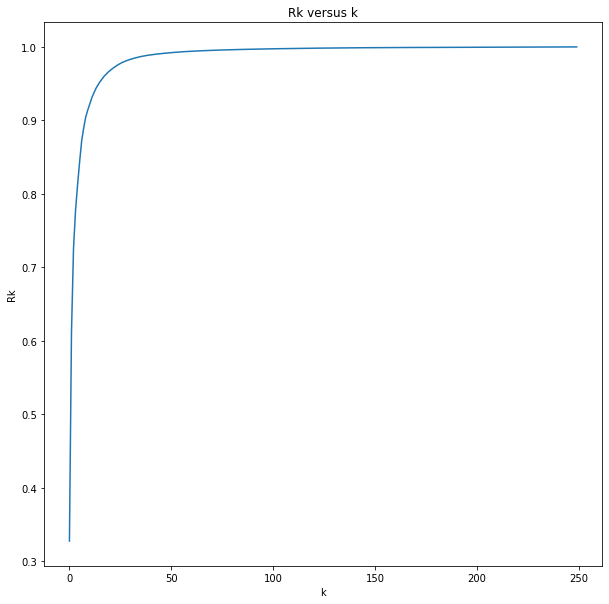

In [ ]:
#Plot the curve Rk vs 
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
ax.plot(R) 
ax.set(title='Rk versus k', ylabel='Rk', xlabel='k')
plt.show()

In [ ]:
for i in range(250):
    if R[i]>=0.9:
        min_r = i
        break
print(min_r, R[min_r])

8 0.9046007252702343


Our h layer will be h = 8 since it covers 90.5% of total variance. 

Set up the AutoEncoder

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import Constant

# constructing the autoencoder

# determine h through PCA on your own data
# try to find suitable initializers for your own data
h = 8
model = Sequential()
model.add(Dense(h, activation='relu', input_dim=250, bias_initializer=Constant(value=10)))
model.add(Dense(250, activation='relu', bias_initializer=Constant(value=5)))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 8)                 2008      
_________________________________________________________________
dense_5 (Dense)              (None, 250)               2250      
Total params: 4,258
Trainable params: 4,258
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras import optimizers, losses

model.compile(optimizer=optimizers.SGD(learning_rate=0.05, decay=1e-7), loss='mean_squared_error')

In [ ]:
from tensorflow.keras import callbacks

# the following callback to record losses after each batch
class MyHistory(callbacks.Callback):
    def on_train_begin(self, logs={}):
      self.MSEtrain = []
      self.MSEtest = []
    def on_batch_end(self, batch, logs={}):
      self.MSEtrain.append(self.model.evaluate(Xtrain,Xtrain,verbose = 0))
      self.MSEtest.append(self.model.evaluate(Xtest,Xtest,verbose = 0))

MyMonitor = MyHistory()

# Keras built-in early-stopping callback
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100, restore_best_weights=True)

In [ ]:
#@title
Monitor = model.fit(Xtrain, Xtrain, epochs=900, batch_size=50, callbacks = [MyMonitor, es], validation_data = (Xtest, Xtest), verbose = 2, workers = 10)

Streaming output truncated to the last 5000 lines.
19/19 - 10s - loss: 0.0188 - val_loss: 0.0180
Epoch 663/900
19/19 - 10s - loss: 0.0173 - val_loss: 0.0183
Epoch 664/900
19/19 - 10s - loss: 0.0171 - val_loss: 0.0180
Epoch 665/900
19/19 - 10s - loss: 0.0174 - val_loss: 0.0179
Epoch 666/900
19/19 - 10s - loss: 0.0177 - val_loss: 0.0176
Epoch 667/900
19/19 - 10s - loss: 0.0176 - val_loss: 0.0180
Epoch 668/900
19/19 - 10s - loss: 0.0201 - val_loss: 0.0182
Epoch 669/900
19/19 - 10s - loss: 0.0186 - val_loss: 0.0180
Epoch 670/900
19/19 - 10s - loss: 0.0168 - val_loss: 0.0176
Epoch 671/900
19/19 - 10s - loss: 0.0173 - val_loss: 0.0177
Epoch 672/900
19/19 - 10s - loss: 0.0169 - val_loss: 0.0175
Epoch 673/900
19/19 - 10s - loss: 0.0187 - val_loss: 0.0176
Epoch 674/900
19/19 - 10s - loss: 0.0164 - val_loss: 0.0174
Epoch 675/900
19/19 - 10s - loss: 0.0174 - val_loss: 0.0177
Epoch 676/900
19/19 - 10s - loss: 0.0177 - val_loss: 0.0181
Epoch 677/900
19/19 - 10s - loss: 0.0169 - val_loss: 0.0175
Epo

In [ ]:
#np.save('./history_sim', Monitor.history)

In [ ]:
#@title
#history = np.load('history_sim').item()

In [ ]:
model.save("model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
from keras.models import load_model
 
# load model
model = load_model('model.h5')

In [ ]:
#Evaluate the model
round(model.evaluate(Xtest,Xtest),2)

4/4 [==============================] - 0s 2ms/step - loss: 0.0158


0.02

In [ ]:
#Access MSEtrain and MSEtest via MyMonitor.MSEtrain and MyMonitor.MSEtest.
MSEtrain = MyMonitor.MSEtrain
MSEtest = MyMonitor.MSEtest

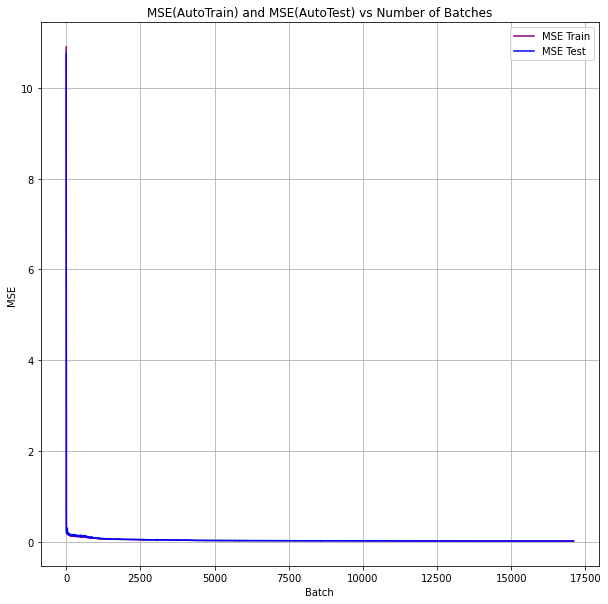

In [ ]:
#plot MSEtrain and MSEtest versus batches
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
ax.plot(MSEtrain, color = 'purple', label = 'MSE Train')
ax.plot(MSEtest, color = 'blue', label = 'MSE Test') 
ax.set(title='MSE(AutoTrain) and MSE(AutoTest) vs Number of Batches', ylabel='MSE', xlabel='Batch')
plt.legend()
plt.grid(True)
plt.show()

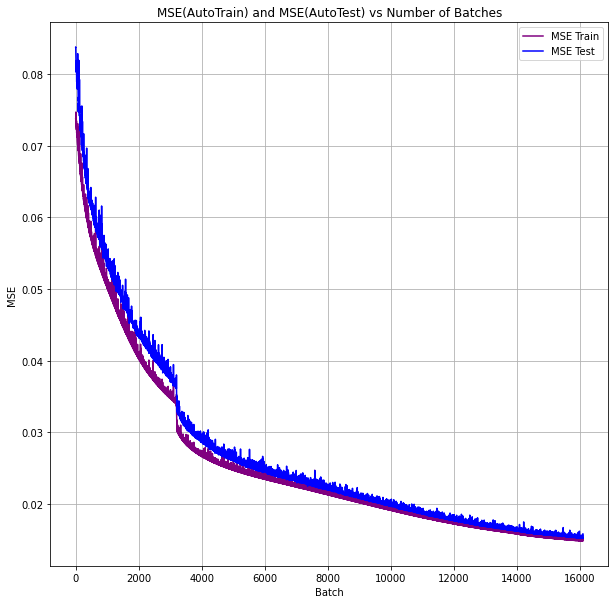

In [ ]:
#It seems like the first 20 MSE values are extremely higher compared to the rest, so let's zoom in and see the smaller values
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
ax.plot(MSEtrain[1000:], color = 'purple', label = 'MSE Train')
ax.plot(MSEtest[1000:], color = 'blue', label = 'MSE Test') 
ax.set(title='MSE(AutoTrain) and MSE(AutoTest) vs Number of Batches', ylabel='MSE', xlabel='Batch')
plt.legend()
plt.grid(True)
plt.show()

As we can see, both our MSEtrain and MSEtest seem to have extremely similar values. We begin our model with approximately 12% MSE error, and by the end of the run the MSE drops by a substantial amount (a little less than 0.02%). This is good and indicates that our data values are dispersed closely to the central moment. However, our MSE's are so low and so close in value that this may indicate overfitting. We need to see a balance of MSE scores (very low MSE for training data and high MSE for test data)

In [ ]:
print(round(max(MSEtrain),2))
print(round(max(MSEtest),2))

10.91
10.76


Compute Compressed Inputs

In [ ]:
# extract the hidden layer

Htrain = model.layers[0](Xtrain.values).numpy()
Htest = model.layers[0](Xtest.values).numpy()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [ ]:
Htrain

array([[ 7.002152 ,  9.407033 ,  6.7574267, ...,  9.274195 ,  8.2638235,
         9.187264 ],
       [ 8.167513 ,  7.933757 ,  8.83315  , ...,  8.727893 ,  7.9942904,
         8.322694 ],
       [ 8.358939 ,  4.4510474,  9.721185 , ...,  6.857221 ,  8.952982 ,
         8.421789 ],
       ...,
       [ 6.211541 ,  8.486383 ,  7.1595783, ..., 10.38715  ,  9.560092 ,
         7.4207277],
       [11.1929035,  7.1361065,  7.3695006, ...,  6.90593  ,  9.025454 ,
         9.254482 ],
       [ 6.448947 ,  7.2078867,  6.1996984, ..., 11.665323 ,  8.883142 ,
         6.5414467]], dtype=float32)

In [ ]:
print(Ytest.shape)
print(Ytrain.shape)

(100,)
(902,)


In [ ]:
# make sure Z is a two-dimensional numpy array
# shape (900,) is different from shape (900,1)

Ztrain = np.reshape(Ytrain.values,(902,1))
Ztest = np.reshape(Ytest.values,(100,1))

901 cases in NewTrain

numwth = h*k+k+k+1 =< 902

here for my data h = 8, so k=90

In [ ]:
mlp = Sequential()
mlp.add(Dense(90, activation='relu', input_dim=h, bias_initializer=Constant(value=5)))
mlp.add(Dense(1, activation='relu', bias_initializer=Constant(value=40)))
mlp.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 90)                810       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 91        
Total params: 901
Trainable params: 901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# configure suitable lr and decay

mlp.compile(optimizer=optimizers.SGD(learning_rate=0.0001, decay=1e-6), loss='mean_squared_error')

In [ ]:
class mlpMyHistory(callbacks.Callback):
    def on_train_begin(self, logs={}):
      self.MSEtrain = []
      self.MSEtest = []
    def on_batch_end(self, batch, logs={}):
      self.MSEtrain.append(self.model.evaluate(Htrain,Ztrain,verbose = 0))
      self.MSEtest.append(self.model.evaluate(Htest,Ztest,verbose = 0))

mlpMyMonitor = mlpMyHistory()

es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200, restore_best_weights=True)

In [ ]:
mlpMonitor = mlp.fit(Htrain, Ztrain, epochs=900, batch_size=32, callbacks = [mlpMyMonitor, es], validation_data = (Htest, Ztest), verbose = 2)

Epoch 1/900
29/29 - 2s - loss: 0.8646 - val_loss: 0.7149
Epoch 2/900
29/29 - 2s - loss: 0.7913 - val_loss: 0.8021
Epoch 3/900
29/29 - 3s - loss: 0.8102 - val_loss: 0.7573
Epoch 4/900
29/29 - 3s - loss: 0.6865 - val_loss: 0.7366
Epoch 5/900
29/29 - 3s - loss: 0.7205 - val_loss: 0.7171
Epoch 6/900
29/29 - 2s - loss: 0.7903 - val_loss: 0.7474
Epoch 7/900
29/29 - 2s - loss: 0.7214 - val_loss: 0.7179
Epoch 8/900
29/29 - 2s - loss: 0.7148 - val_loss: 0.6895
Epoch 9/900
29/29 - 2s - loss: 0.7600 - val_loss: 0.8152
Epoch 10/900
29/29 - 2s - loss: 0.6440 - val_loss: 0.8176
Epoch 11/900
29/29 - 2s - loss: 0.7372 - val_loss: 0.6545
Epoch 12/900
29/29 - 2s - loss: 0.7529 - val_loss: 0.6807
Epoch 13/900
29/29 - 2s - loss: 0.6331 - val_loss: 0.6474
Epoch 14/900
29/29 - 2s - loss: 0.6581 - val_loss: 0.6559
Epoch 15/900
29/29 - 3s - loss: 0.6217 - val_loss: 0.6378
Epoch 16/900
29/29 - 2s - loss: 0.7648 - val_loss: 0.6435
Epoch 17/900
29/29 - 2s - loss: 0.6063 - val_loss: 0.7185
Epoch 18/900
29/29 - 2s

In [ ]:
round(mlp.evaluate(Htest,Ztest),2)

4/4 [==============================] - 0s 1ms/step - loss: 0.0132


0.01

In [ ]:
#Get MSENewTrain and MSENewTest
MSENewTrain = mlpMyMonitor.MSEtrain
MSENewTest = mlpMyMonitor.MSEtest

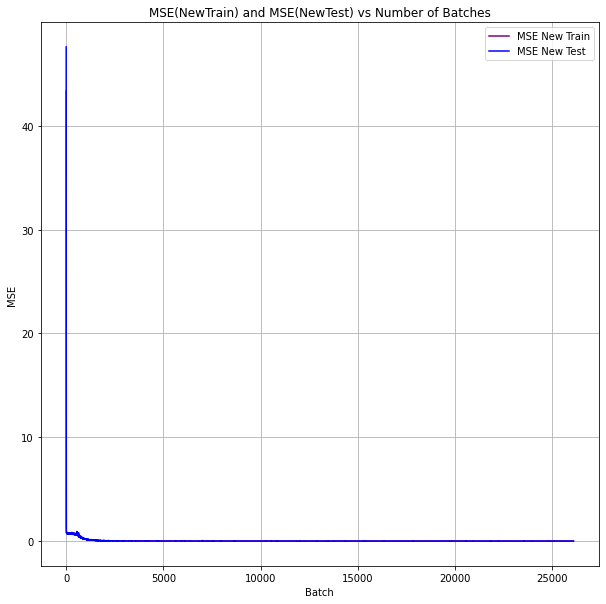

In [ ]:
#Plot MSENewTrain and MSENewTest
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
ax.plot(MSENewTrain, color = 'purple', label = 'MSE New Train')
ax.plot(MSENewTest, color = 'blue', label = 'MSE New Test') 
ax.set(title='MSE(NewTrain) and MSE(NewTest) vs Number of Batches', ylabel='MSE', xlabel='Batch')
plt.legend()
plt.grid(True)
plt.show()

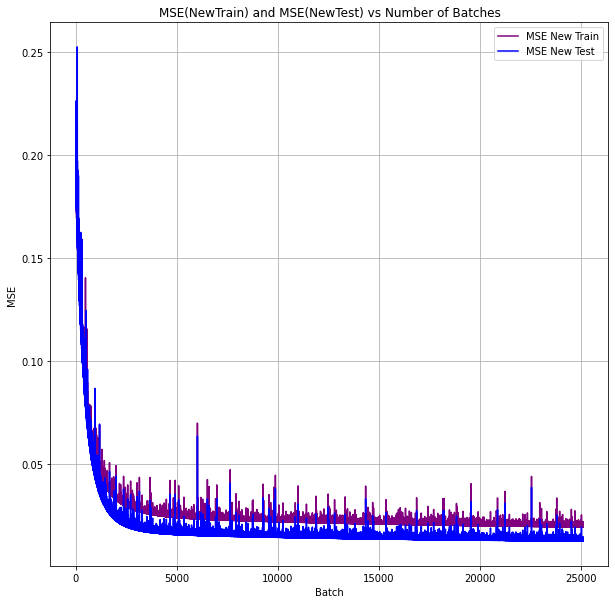

In [ ]:
#It seems like the first 20 MSE values are extremely higher compared to the rest, so let's zoom in and see the smaller values
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
ax.plot(MSENewTrain[1000:], color = 'purple', label = 'MSE New Train')
ax.plot(MSENewTest[1000:], color = 'blue', label = 'MSE New Test') 
ax.set(title='MSE(NewTrain) and MSE(NewTest) vs Number of Batches', ylabel='MSE', xlabel='Batch')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print("MSENewTrain max and min: ", round(max(MSENewTrain),2), round(min(MSENewTrain),2))
print("MSENewTest max and min: ", round(max(MSENewTest),2), round(min(MSENewTest),2))

MSENewTrain max and min:  43.34 0.02
MSENewTest max and min:  47.58 0.01


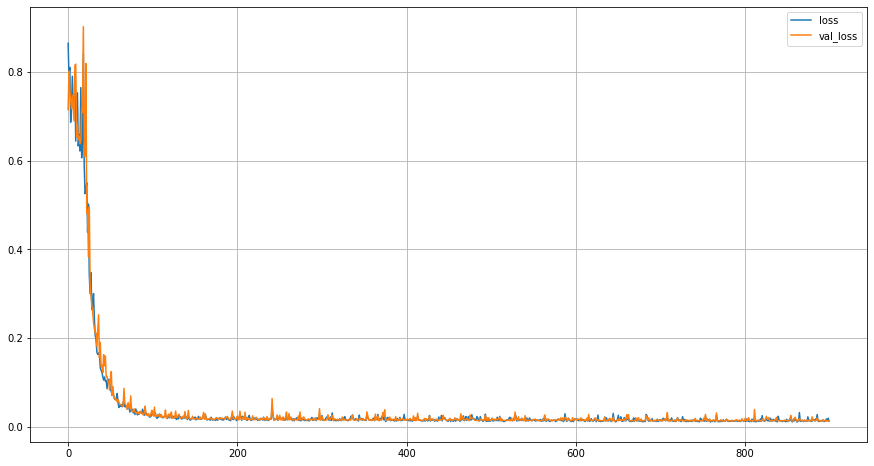

In [ ]:
pd.DataFrame(mlpMonitor.history).plot(figsize=(15,8))
plt.grid(True)

In [ ]:
y_train_pred = mlp.predict(Htrain)
y_test_pred = mlp.predict(Htest)

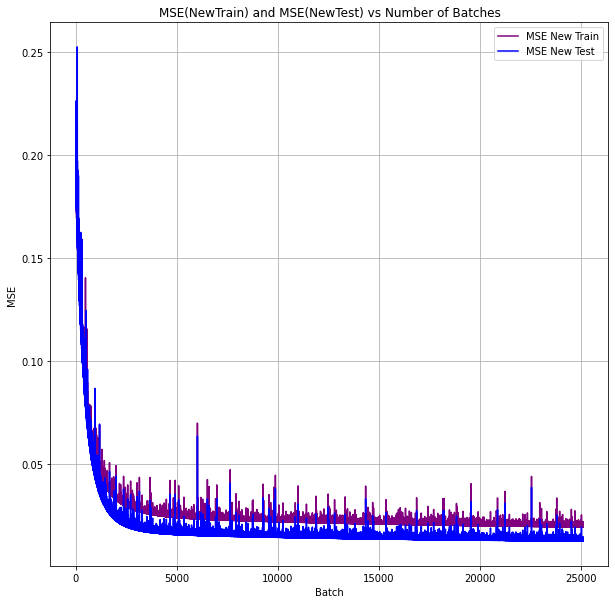

In [ ]:
#It seems like the first 20 MSE values are extremely higher compared to the rest, so let's zoom in and see the smaller values
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
ax.plot(MSENewTrain[1000:], color = 'purple', label = 'MSE New Train')
ax.plot(MSENewTest[1000:], color = 'blue', label = 'MSE New Test') 
ax.set(title='MSE(NewTrain) and MSE(NewTest) vs Number of Batches', ylabel='MSE', xlabel='Batch')
plt.legend()
plt.grid(True)
plt.show()

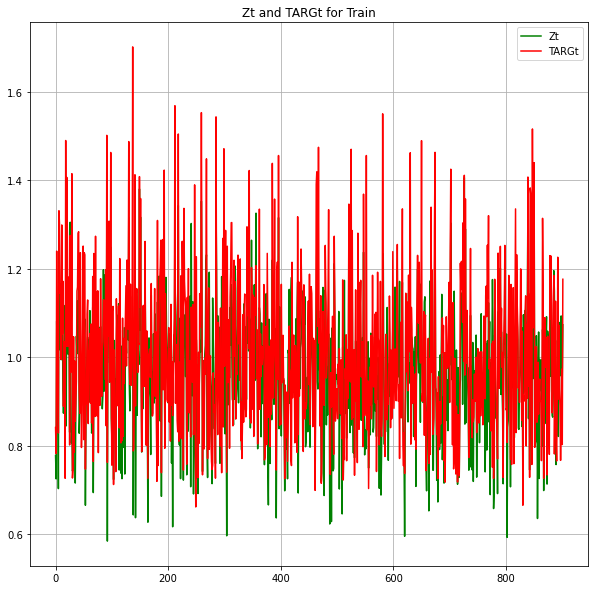

In [ ]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
ax.plot(y_train_pred, color = 'green', label = 'Zt')
ax.plot(Ztrain, color = 'red', label = 'TARGt')
ax.set(title='Zt and TARGt for Train')
plt.legend()
plt.grid(True)
plt.show()

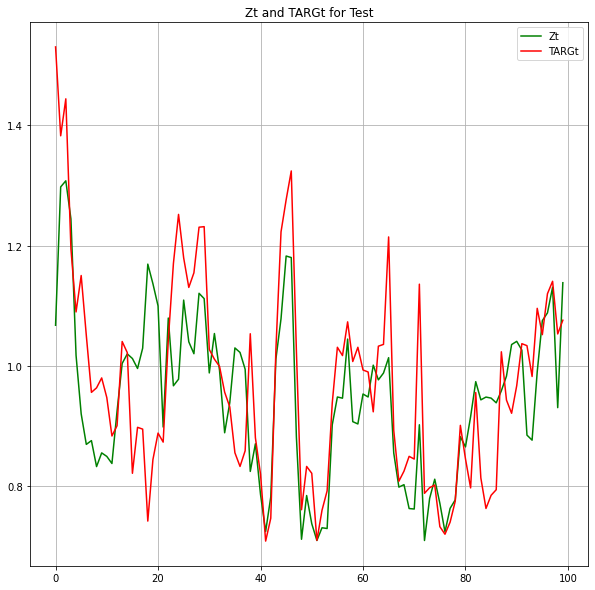

In [ ]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
ax.plot(y_test_pred, color = 'green', label = 'Zt')
ax.plot(Ztest, color = 'red', label = 'TARGt')
ax.set(title='Zt and TARGt for Test')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Computr MREP(NewTest) = avg(|Zt - TARGt| / TARGt)
MREP_NewTrain = np.average(abs(y_train_pred - Ztrain) / Ztrain)
MREP_NewTest = np.average(abs(y_test_pred - Ztest) / Ztest)

In [ ]:
print("MREP New Train: ", round(MREP_NewTrain, 2))
print("MREP New Test: ", round(MREP_NewTest,2))

MREP New Train:  0.11
MREP New Test:  0.09
